In [ ]:
!pip install geopandas 
!pip install geopy
!pip install geopandas
!pip install libpysal
!pip install splot
!sudo apt-get update
!sudo apt install -y gdal-bin python-gdal python3-gdal 
!sudo apt install -y python3-rtree
!pip install pysal

In [2]:
#Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot
from splot.esda import lisa_cluster
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [3]:
#Loading safecity data for delhi
sh = pd.read_csv('sh_geolocation.csv')
delhi = sh[sh['state']=='Delhi']

In [4]:
#Loading delhi hex 1 km shapefile
delhi_hex = gpd.read_file('delhi_hex_1km.json').to_crs(fiona.crs.from_epsg(2263))
delhi_hex.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,left,top,right,bottom,min_lon,min_lat,max_lon,max_lat,cluster_lon,cluster_lat,nightlights,geometry
0,201.0,7.398443e+06,3.521635e+06,7.399598e+06,3.520635e+06,76.834893,28.590825,76.835526,28.591400,76.835165,28.591131,NaN,"POLYGON ((29385927.322 28808304.544, 29385709...."
1,202.0,7.398443e+06,3.520635e+06,7.399598e+06,3.519635e+06,76.832916,28.581956,76.838164,28.590825,76.835325,28.585848,1.258015,"POLYGON ((29389278.060 28808192.726, 29389080...."
2,203.0,7.398443e+06,3.519635e+06,7.399598e+06,3.518635e+06,76.833018,28.573087,76.838164,28.581956,76.835343,28.577948,0.000000,"POLYGON ((29392455.408 28809218.429, 29389278...."
3,204.0,7.398443e+06,3.518635e+06,7.399598e+06,3.517635e+06,76.834651,28.565519,76.838164,28.573087,76.836257,28.569340,1.482027,"POLYGON ((29395166.748 28810093.823, 29392455...."
4,205.0,7.398443e+06,3.517635e+06,7.399598e+06,3.516635e+06,76.836703,28.558551,76.838164,28.561946,76.837398,28.560094,NaN,"POLYGON ((29397663.569 28810900.059, 29396447...."


In [5]:
#Creating rtree indexes for spatial matching of incidents and hex clusters
index = rtree.Rtree()
for idx,geometry in enumerate(delhi_hex.geometry):
  index.insert(idx, geometry.bounds)

In [6]:
#Spatial matching of incidents and hex clusters

import csv
import pyproj
import shapely.geometry as geom

proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}

for i, row in delhi.iterrows():
  p = geom.Point(proj(float(row['lon']), float(row['lat'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if delhi_hex.geometry[idx].contains(p):
      license = row['incident_id']
      match = delhi_hex.id[idx]
      counts[license] = match

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [7]:
#Creating Dataframe with matched hex clusters to each incident
geotags = pd.DataFrame(counts.items())
geotags = geotags.rename(columns={0:'incident_id',1:'id'})
geotags.head()

,incident_id,id
0,incident_13635,2273.0
1,incident_13625,1869.0
2,incident_13616,3061.0
3,incident_13617,3120.0
4,incident_13615,1869.0


In [8]:
#Merging hex clusters with delhi dataframe
location_counts = pd.DataFrame(geotags[['id','incident_id']].groupby('id').agg('count'))
location_counts.head()

,incident_id
id,
923.0,1
1151.0,1
1152.0,17
1207.0,1
1209.0,1


In [9]:
#merging
delhi_hex = delhi_hex.merge(location_counts, on = 'id', how='left')
delhi_hex.head()

,id,left,top,right,bottom,min_lon,min_lat,max_lon,max_lat,cluster_lon,cluster_lat,nightlights,geometry,incident_id
0,201.0,7.398443e+06,3.521635e+06,7.399598e+06,3.520635e+06,76.834893,28.590825,76.835526,28.591400,76.835165,28.591131,NaN,"POLYGON ((29385927.322 28808304.544, 29385709....",NaN
1,202.0,7.398443e+06,3.520635e+06,7.399598e+06,3.519635e+06,76.832916,28.581956,76.838164,28.590825,76.835325,28.585848,1.258015,"POLYGON ((29389278.060 28808192.726, 29389080....",NaN
2,203.0,7.398443e+06,3.519635e+06,7.399598e+06,3.518635e+06,76.833018,28.573087,76.838164,28.581956,76.835343,28.577948,0.000000,"POLYGON ((29392455.408 28809218.429, 29389278....",NaN
3,204.0,7.398443e+06,3.518635e+06,7.399598e+06,3.517635e+06,76.834651,28.565519,76.838164,28.573087,76.836257,28.569340,1.482027,"POLYGON ((29395166.748 28810093.823, 29392455....",NaN
4,205.0,7.398443e+06,3.517635e+06,7.399598e+06,3.516635e+06,76.836703,28.558551,76.838164,28.561946,76.837398,28.560094,NaN,"POLYGON ((29397663.569 28810900.059, 29396447....",NaN


In [10]:
#Filtering locations with less than 50 units of nightlights for spatial correlations between incidents and poor lighting
delhi_hex_dark = delhi_hex[delhi_hex['nightlights'] < 50]
delhi_hex_dark.head()

,id,left,top,right,bottom,min_lon,min_lat,max_lon,max_lat,cluster_lon,cluster_lat,nightlights,geometry,incident_id
1,202.0,7.398443e+06,3.520635e+06,7.399598e+06,3.519635e+06,76.832916,28.581956,76.838164,28.590825,76.835325,28.585848,1.258015,"POLYGON ((29389278.060 28808192.726, 29389080....",NaN
2,203.0,7.398443e+06,3.519635e+06,7.399598e+06,3.518635e+06,76.833018,28.573087,76.838164,28.581956,76.835343,28.577948,0.000000,"POLYGON ((29392455.408 28809218.429, 29389278....",NaN
3,204.0,7.398443e+06,3.518635e+06,7.399598e+06,3.517635e+06,76.834651,28.565519,76.838164,28.573087,76.836257,28.569340,1.482027,"POLYGON ((29395166.748 28810093.823, 29392455....",NaN
5,258.0,7.399309e+06,3.521135e+06,7.400464e+06,3.520135e+06,76.835166,28.586390,76.846870,28.591358,76.840886,28.588898,1.870658,"POLYGON ((29385700.110 28808480.126, 29385491....",NaN
6,259.0,7.399309e+06,3.520135e+06,7.400464e+06,3.519135e+06,76.835166,28.577521,76.847156,28.586390,76.841161,28.581956,1.096428,"POLYGON ((29389172.003 28808889.232, 29387394....",NaN


In [11]:
#Calculating spatial correlation for incidents to see if there are clustered together in areas with poor lighting
t = [923,1209,1428,1520,1523,1552,1578,1585,1638,1777,1796,1832,1883,1885,1894,1947,1993,2006,2064,2105,2178,2454,2683,2789,2825,2844,2986,3123,3219,3347]
spatial_dummy = delhi_hex.dropna(subset=['incident_id'])
spatial_dummy = spatial_dummy.loc[~spatial_dummy.id.isin(t)]
y = spatial_dummy['incident_id'].values
x = spatial_dummy['nightlights'].values
w = Queen.from_dataframe(spatial_dummy)
w.transform = 'R'
moran = Moran(y,w,permutations=99)
moran_loc = Moran_Local(y, w, permutations=99)
moran_loc_bv = Moran_Local_BV(y, x, w, permutations=99)
moran_bv = Moran_BV(y, x, w)
moran.I

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
  warnings.warn(message)


0.09901872281184317

In [13]:
#Bivariate spatial correlation between incidents and nightlights
moran_bv.I

0.06703887572791094

In [14]:
#Creating points for label on maps
spatial_dummy["center"] = spatial_dummy["geometry"].centroid
delhi_points = spatial_dummy.copy()
delhi_points.set_geometry("center", inplace = True)

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4930d43978>)

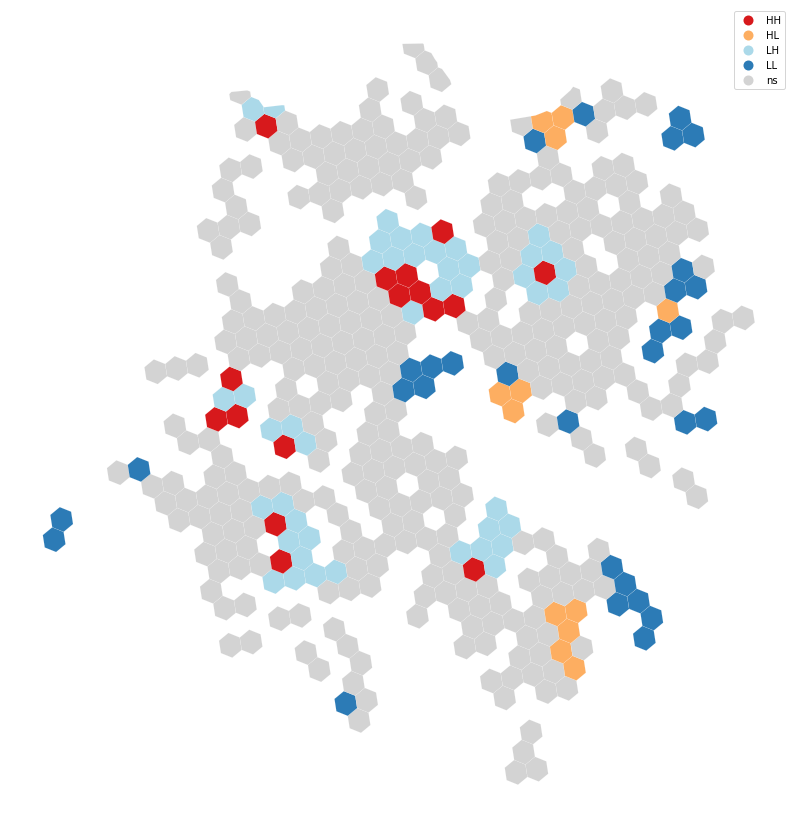

In [15]:
#Visualising the clusters
texts = []

lisa_cluster(moran_loc_bv, spatial_dummy, p=0.05, figsize = (15,15))

In [16]:
spatial_dummy['cluster'] = moran_loc_bv.q 
spatial_dummy[spatial_dummy['cluster']==2]

,id,left,top,right,bottom,min_lon,min_lat,max_lon,max_lat,cluster_lon,cluster_lat,nightlights,geometry,incident_id,center,cluster
346,1151.0,7.413166e+06,3.524135e+06,7.414320e+06,3.523135e+06,76.979052,28.613001,76.991043,28.621873,76.985048,28.617437,42.324787,"POLYGON ((29368998.133 28853534.803, 29367219....",1.0,POINT (29368698.943 28855477.477),2
495,1375.0,7.416630e+06,3.524135e+06,7.417784e+06,3.523135e+06,77.015024,28.613001,77.027014,28.621873,77.021019,28.617437,61.396988,"POLYGON ((29367201.129 28865190.558, 29365422....",9.0,POINT (29366901.142 28867133.109),2
602,1534.0,7.419228e+06,3.532635e+06,7.420383e+06,3.531635e+06,77.042002,28.688436,77.053993,28.697315,77.047998,28.692875,55.207165,"POLYGON ((29338154.059 28869647.329, 29336374....",1.0,POINT (29337853.767 28871587.892),2
609,1541.0,7.419228e+06,3.525635e+06,7.420383e+06,3.524635e+06,77.042002,28.626309,77.053993,28.635182,77.047998,28.630746,55.903034,"POLYGON ((29360963.620 28873175.937, 29359184....",1.0,POINT (29360663.086 28875118.060),2
610,1542.0,7.419228e+06,3.524635e+06,7.420383e+06,3.523635e+06,77.042002,28.617437,77.053993,28.626309,77.047998,28.621873,59.612644,"POLYGON ((29364221.409 28873679.912, 29362442....",1.0,POINT (29363920.841 28875622.259),2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,3215.0,7.445209e+06,3.531635e+06,7.446363e+06,3.530635e+06,77.311789,28.679559,77.323780,28.688436,77.317732,28.684081,79.638397,"POLYGON ((29328377.829 28960857.240, 29329057....",2.0,POINT (29327433.772 28959384.440),2
1839,3216.0,7.445209e+06,3.530635e+06,7.446363e+06,3.529635e+06,77.311789,28.670682,77.318433,28.679559,77.315423,28.675204,62.474525,"POLYGON ((29329057.137 28959873.326, 29329163....",3.0,POINT (29330809.045 28959151.643),2
1844,3221.0,7.445209e+06,3.525635e+06,7.446363e+06,3.524635e+06,77.311789,28.626309,77.323780,28.635182,77.317785,28.630746,75.921898,"POLYGON ((29347308.990 28960551.161, 29345527....",1.0,POINT (29347002.476 28962492.350),2
1857,3271.0,7.446075e+06,3.532135e+06,7.447229e+06,3.531135e+06,77.320782,28.683997,77.327583,28.692875,77.324699,28.688516,63.747921,"POLYGON ((29323748.323 28961777.425, 29324082....",2.0,POINT (29325450.148 28961381.650),2


## Delhi Wards

In [17]:
delhi_wards = gpd.read_file('delhi_wards.geojson').to_crs(fiona.crs.from_epsg(2263))

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
#Creating rtree indexes for spatial matching of incidents and Admin Wards
index = rtree.Rtree()
for idx,geometry in enumerate(delhi_wards.geometry):
  index.insert(idx, geometry.bounds)

In [19]:
#Spatial matching of hex clusters and Admin Wards
import csv
import pyproj
import shapely.geometry as geom

proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}

for i, row in delhi_hex.iterrows():
  p = geom.Point(proj(float(row['cluster_lon']), float(row['cluster_lat'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if delhi_wards.geometry[idx].contains(p):
      license = row['id']
      match = delhi_wards.Ward_Name[idx]
      counts[license] = match

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [20]:
#Creating Dataframe with matched wards to each incident
geotags = pd.DataFrame(counts.items())
geotags = geotags.rename(columns={0:'id',1:'Ward_Name'})
geotags.head()

,id,Ward_Name
0,259.0,KHERA
1,260.0,KHERA
2,262.0,KHERA
3,315.0,KHERA
4,316.0,KHERA


In [24]:
#Getting nightlights data for each Ward
geotags_lights = geotags.merge(delhi_hex[['id','nightlights']], on='id', how='left')
geotags_lights.head()

,id,Ward_Name,nightlights
0,259.0,KHERA,1.096428
1,260.0,KHERA,1.276999
2,262.0,KHERA,3.042365
3,315.0,KHERA,2.256360
4,316.0,KHERA,2.507080


In [25]:
#Grouping nightlights by Ward_Name
location_counts = pd.DataFrame(geotags_lights[['Ward_Name','nightlights']].groupby('Ward_Name').agg({'nightlights':'sum'}))
location_counts.head()

,nightlights
Ward_Name,
ADARASH NAGAR,158.697533
ALIPUR,873.033416
AMAR COLONY,63.055599
ANAND VIHAR,335.713539
ANARKALI,50.153183


In [27]:
delhi_wards_nightlights = delhi_wards.merge(location_counts, on ='Ward_Name', how = 'left')
delhi_wards_nightlights.head()

,Ward_Name,Ward_No,geometry,nightlights
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930....",47.890144
1,DELHI CANTT CHARGE 2,CANT_2,"POLYGON ((29358027.457 28909969.975, 29358384....",291.283568
2,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",433.165951
3,DELHI CANTT CHARGE 5,CANT_5,"POLYGON ((29378413.241 28906681.110, 29378447....",102.359127
4,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",662.167868


In [29]:
#Incidents mapping
#Creating rtree indexes for spatial matching of incidents and Admin Wards
index = rtree.Rtree()
for idx,geometry in enumerate(delhi_wards.geometry):
  index.insert(idx, geometry.bounds)

In [30]:
#Spatial matching of incidents and Admin Wards

import csv
import pyproj
import shapely.geometry as geom

proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    

counts = {}

for i, row in delhi.iterrows():
  p = geom.Point(proj(float(row['lon']), float(row['lat'])))
  match = None
  for idx in index.intersection((p.x, p.y, p.x, p.y)):
    if delhi_wards.geometry[idx].contains(p):
      license = row['incident_id']
      match = delhi_wards.Ward_Name[idx]
      counts[license] = match

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [31]:
#Creating Dataframe with matched wards to each incident
geotags = pd.DataFrame(counts.items())
geotags = geotags.rename(columns={0:'incident_id',1:'Ward_Name'})
geotags.head()

,incident_id,Ward_Name
0,incident_13635,DELHI CANTT CHARGE 3
1,incident_13625,ROHINI SOUTH
2,incident_13616,OKHLA
3,incident_13617,SARITA VIHAR
4,incident_13615,ROHINI SOUTH


In [35]:
#Merging city wards with delhi dataframe
location_counts = pd.DataFrame(geotags[['Ward_Name','incident_id']].groupby('Ward_Name').agg('count'))
location_counts.head()

,incident_id
Ward_Name,
ADARASH NAGAR,17
ALIPUR,3
AMAR COLONY,54
AMBEDKAR NAGAR,10
ANAND VIHAR,12


In [36]:
delhi_wards_nightlights = delhi_wards_nightlights.merge(location_counts, on = 'Ward_Name', how='left')
delhi_wards_nightlights.head()

,Ward_Name,Ward_No,geometry,nightlights,incident_id
0,DELHI CANTT CHARGE 1,CANT_1,"POLYGON ((29356131.178 28902372.508, 29359930....",47.890144,3.0
1,DELHI CANTT CHARGE 2,CANT_2,"POLYGON ((29358027.457 28909969.975, 29358384....",291.283568,NaN
2,DELHI CANTT CHARGE 4,CANT_4,"POLYGON ((29375328.819 28913751.798, 29375422....",433.165951,7.0
3,DELHI CANTT CHARGE 5,CANT_5,"POLYGON ((29378413.241 28906681.110, 29378447....",102.359127,NaN
4,DELHI CANTT CHARGE 6,CANT_6,"POLYGON ((29370794.406 28901102.271, 29371452....",662.167868,5.0


In [58]:
#Calculating spatial correlation for incidents to see if there are clustered together in areas with poor lighting
t = ['GOKALPUR','SHIV VIHAR','JAITPUR','SAGARPUR']
spatial_dummy = delhi_wards_nightlights.dropna(subset=['incident_id','nightlights'])
spatial_dummy = spatial_dummy.loc[~spatial_dummy.Ward_Name.isin(t)]
y = spatial_dummy['incident_id'].values
x = spatial_dummy['nightlights'].values
w = Queen.from_dataframe(spatial_dummy)
w.transform = 'R'
moran = Moran(y,w,permutations=99)
moran_loc = Moran_Local(y, w, permutations=99)
moran_loc_bv = Moran_Local_BV(y, x, w, permutations=99)
moran_bv = Moran_BV(y, x, w)
moran.I

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


0.14306484015614698

In [59]:
moran_bv.I

0.06912557648029022

In [47]:
y

array([  3.,   7.,   5.,   1.,  67., 164.,  38.,   9., 439.,  23.,  17.,
        33.,  38.,   5.,  19.,  44.,   3.,   4.,   2.,  36.,  20.,  12.,
         4., 132.,   1., 109.,  14.,   2.,   1.,   2.,   2.,   5.,   1.,
        12.,   2.,  29.,   3.,  16.,  54.,  13.,  25.,  10.,  57.,  47.,
        59.,  10.,  29.,   4.,  10.,  57.,   3.,   3.,   2.,   2.,  22.,
         5.,  28.,  33.,  26.,   6.,  18.,   2.,   8.,  10.,   1., 124.,
         1.,  36.,   2., 180., 127.,   4.,   2.,  10.,   9.,   6.,   4.,
         4.,  13.,   2.,   7.,   1.,  14.,   1.,   8.,  13.,  11.,  13.,
         3.,   6.,  17.,  83.,   2.,   2.,   6.,  46.,   9.,   9.,  20.,
         3.,   4.,   1.,   3.,   1., 265.,  18.,   4.,  10.,   4.,   3.,
         9.,   5.,   4.,   6.,  14.,   1.,   6.,   3.,   3.,  10.,   7.,
         8.,   3.,  19.,   8.,  10.,  41.,   4.,  16.,  29.,   8.,  28.,
         1.,   8.,   3.,   1.,   2.,   6.,  13.,   1.,   5.,  15.,   6.,
        12.,   3.,   1.,   7.,   2.,   3.,   1.,  1

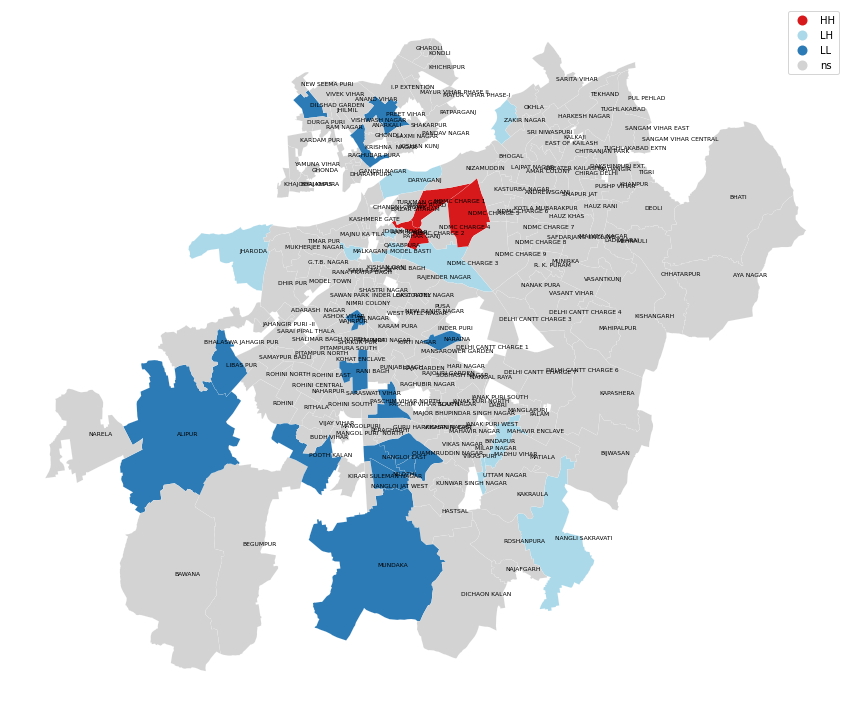

In [63]:
#Visualising the clusters
#Creating points for label on maps
spatial_dummy["center"] = spatial_dummy["geometry"].centroid
delhi_points = spatial_dummy.copy()
delhi_points.set_geometry("center", inplace = True)

texts = []

lisa_cluster(moran_loc, spatial_dummy, p=0.05, figsize = (15,15))
for x, y, label in zip(delhi_points.geometry.x, delhi_points.geometry.y, delhi_points["Ward_Name"]):
    texts.append(plt.text(x, y, label, fontsize = 6))
plt.show()

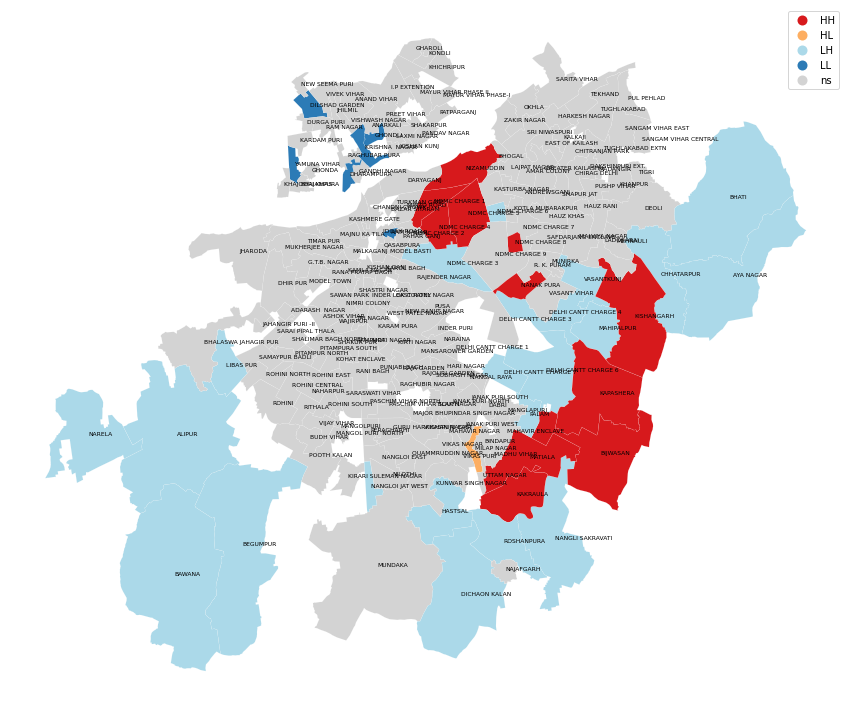

In [64]:
texts = []

lisa_cluster(moran_loc_bv, spatial_dummy, p=0.05, figsize = (15,15))
for x, y, label in zip(delhi_points.geometry.x, delhi_points.geometry.y, delhi_points["Ward_Name"]):
    texts.append(plt.text(x, y, label, fontsize = 6))
plt.show()

In [ ]:
!pip install contextily

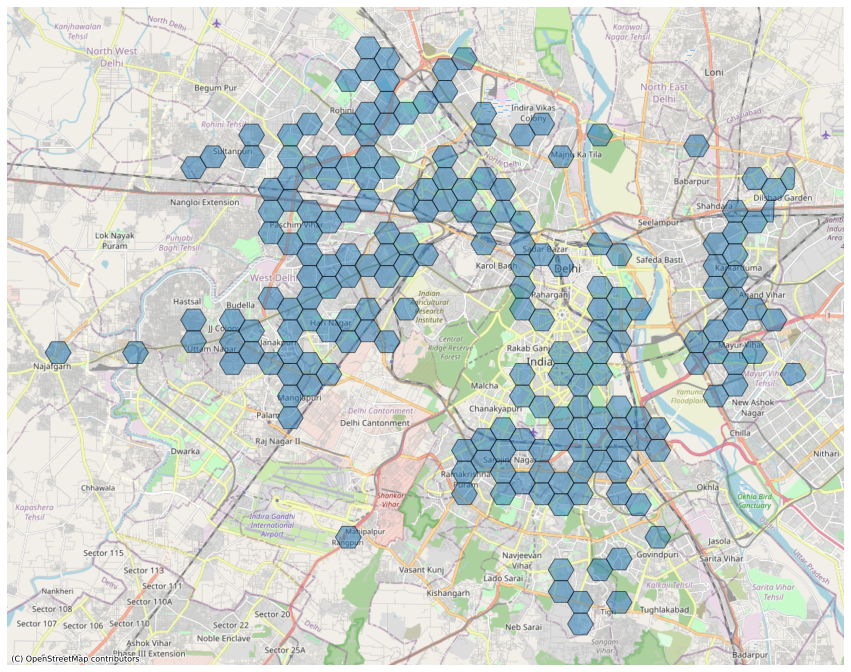

In [223]:
#Visualising High Redline - Rent Correlations (HH)
import contextily as ctx
ax = spatial_dummy[spatial_dummy['cluster']==2].to_crs('EPSG:3857').plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [225]:
spatial_dummy.to_crs('EPSG:4326').to_file('delhi_correlation_clusters.json', driver='GeoJSON')